In [154]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore

In [155]:
#Import training set
train_df = pd.read_csv('data/train.csv', index_col="Id")
test_df = pd.read_csv('data/test.csv', index_col="Id")


In [156]:
#Overview of dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [157]:
#Check for duplicates
print(f"There is {train_df.duplicated().sum()} duplicates")

There is 0 duplicates


## 1. Visualization of Missing values

In [158]:
#Check for missing values
def calculate_NaN(df: pd.DataFrame, as_percentage: bool = False):
    if as_percentage:
        NaN_df = df.isna().mean() * 100

    else:
        NaN_df = df.isna().sum()
    features_with_missing = NaN_df[NaN_df > 0].sort_values(ascending=False)
    return NaN_df, features_with_missing

NaN_df, features_with_missing = calculate_NaN(train_df, True)

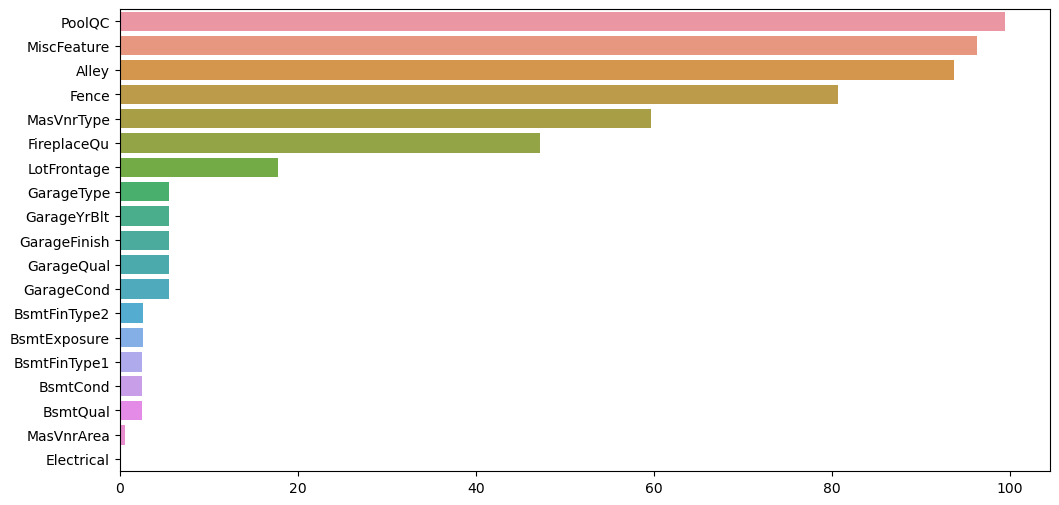

In [159]:
#Plot distribution of missing values
plt.figure(figsize=(12,6))
sns.barplot(y=features_with_missing.index, x=features_with_missing.values)
plt.show()

## 2. Visualization of outliers for numerical features

In [160]:
#GET ALL THE NUMERICAL FEATURES
numerical_features = train_df.select_dtypes(include=[np.number]).columns
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [161]:
#CHECKING FOR NUMBER OF UNIQUE VALUES 
def unique_values(df: pd.DataFrame, numerical_features):
    temp_list = []
    for feature in numerical_features:
        unique_vals = df[feature].nunique()
        temp_list.append({'feature': feature, 'unique_vals_count': unique_vals})
    unique_vals_df = pd.DataFrame(temp_list)
    return unique_vals_df

unique_values_df = unique_values(train_df, numerical_features)
unique_values_df.sort_values(by="unique_vals_count", ascending=False, inplace=True)
unique_values_df

,feature,unique_vals_count
2,LotArea,1073
15,GrLivArea,861
10,BsmtUnfSF,780
12,1stFlrSF,753
11,TotalBsmtSF,721
36,SalePrice,663
8,BsmtFinSF1,637
26,GarageArea,441
13,2ndFlrSF,417
7,MasVnrArea,327


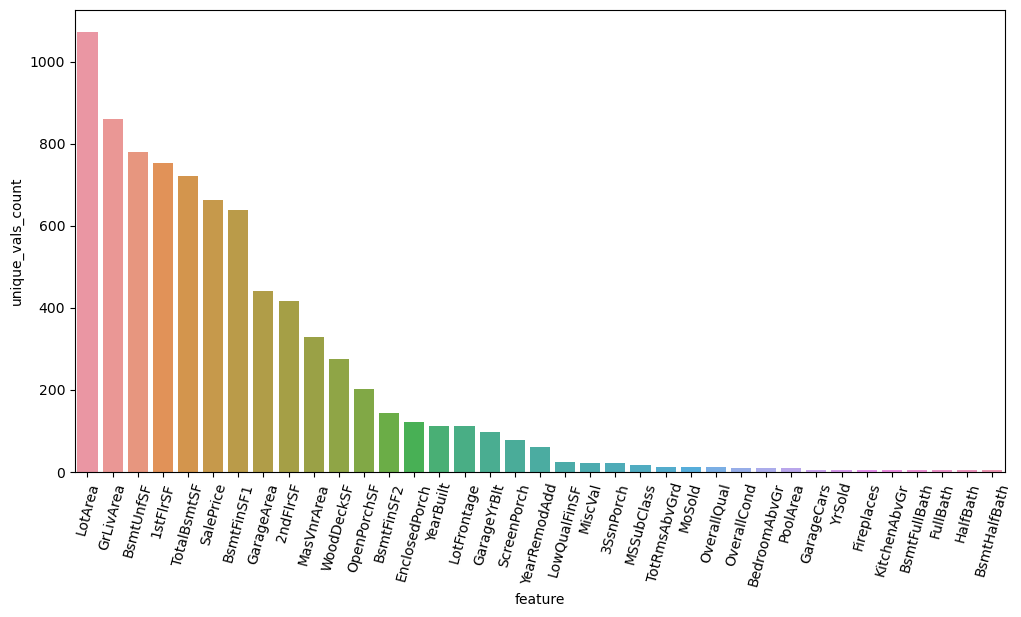

In [162]:
#PLOT NUMBER OF UNIQUE VALUES TO LOOK FOR RELEVANT FEATURES THAT MAY HAVE OUTLINERS
plt.figure(figsize=(12,6))
sns.barplot(data=unique_values_df, y="unique_vals_count", x='feature')
plt.xticks(rotation=75)
plt.show()

In [163]:
#WANT TO LOOK FOR OUTLIERS FOR EVERY FEATURE WITH MORE THAN 50 UNIQUE VALUES
high_unique_features = unique_values_df[unique_values_df["unique_vals_count"] > 50]["feature"].to_list()

In [164]:
def plot_outliers(df : pd.DataFrame, feature : str, target : str = "SalePrice"):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    sns.scatterplot(data=train_df, x=feature, y=target, ax=axes[0])
    sns.boxplot(data=train_df, y=feature, ax=axes[1])
    plt.tight_layout()
    plt.show()

In [165]:
#SCATTERPLOT AND BOXPLOT FOR SELECTED FEATURES
def plot_outliers_features(df : pd.DataFrame, features : list, target : str = "SalePrice"):
    fig, axes = plt.subplots((len(features)), 2, figsize=(8, 50))
    i = 0
    for feature in features:
        sns.scatterplot(data=train_df, x=feature, y=target, ax=axes[i,0])
        sns.boxplot(data=train_df, y=feature, ax=axes[i,1])
        i+=1
    plt.tight_layout()
    plt.show()

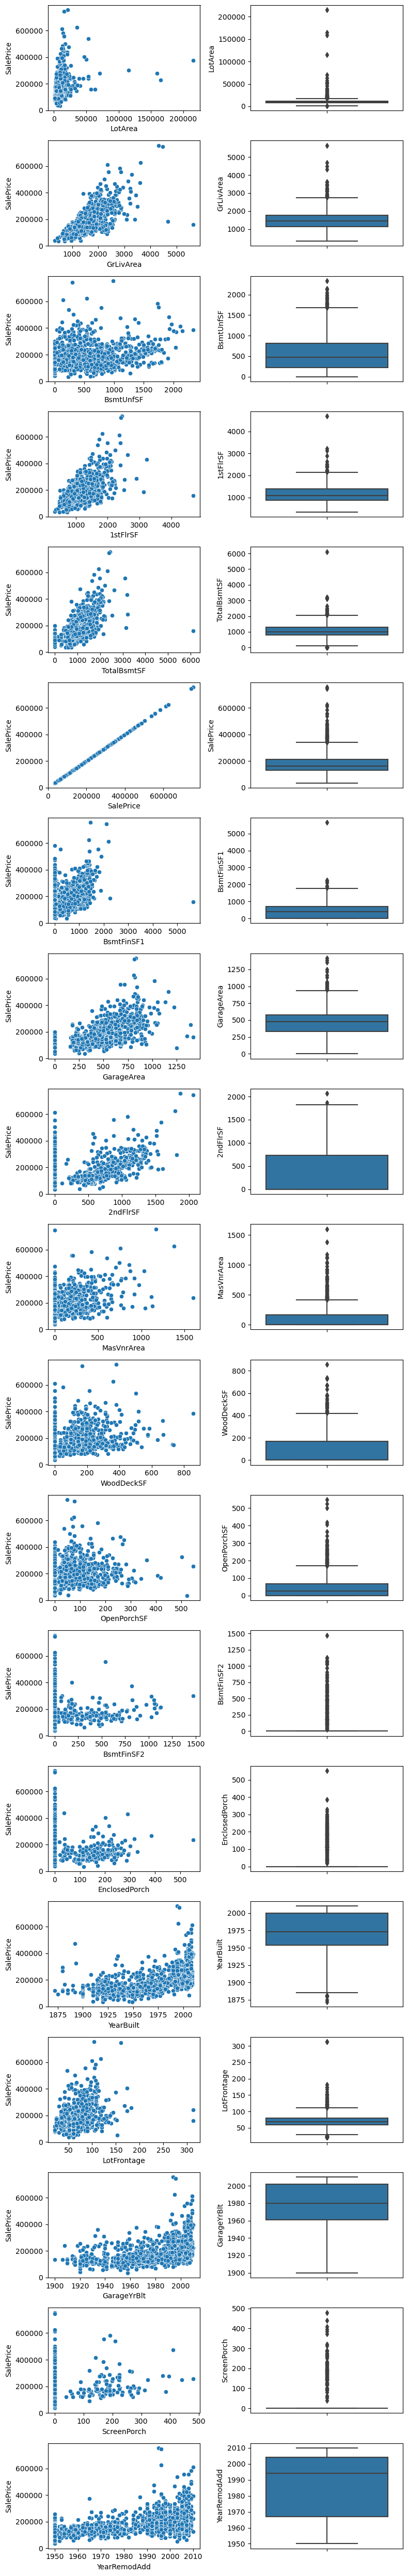

In [166]:
plot_outliers_features(train_df, high_unique_features)

The following features/columns have some outliers: 
- LotFrontage
- LotArea
- GrLivArea
- BsmtFinSF1
- TotalBsmtSF
- 1stFlrSF
- MasVnrArea

To decide the treshhold for remoiving the outliers we do some more analysis of the datapoints for both the train-set and test-set

### 2.2 Outlier analysis to find treshholds

In [167]:
def outlier_analysis(train_df : pd.DataFrame, test_df : pd.DataFrame, feature : str): 
    #Scatterplot of the 50 highest value in the train-set and test-set
    fig, axes = plt.subplots(1,3, figsize = (12,4))
    sns.scatterplot(x = train_df[feature].sort_values(ascending=False)[:50], y=[10] * len(train_df[:50]), label = "Train data", color = "blue", ax = axes[0])
    sns.scatterplot(x=test_df[feature].sort_values(ascending=False)[:50], y=[20] * len(test_df[:50]), label = "Test data",color = "red", ax = axes[0])
    axes[0].set_title(f"Fig1: Scatter Plot of {feature} comparing train and test data", fontsize = 10)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    #CDF plot of both datasets.  
    sns.ecdfplot(x= train_df[feature], color = "blue", label="Train data", ax = axes[1])
    sns.ecdfplot(test_df[feature], label="Test data", color="red", ax=axes[1])
    axes[1].set_title(f"Fig2: CDF of {feature}", fontsize = 10)
    axes[1].grid(True, linestyle="--", alpha=0.5)
    outlier_threshold = train_df[feature].quantile(0.99)
    axes[1].axvspan(outlier_threshold, train_df[feature].max(), color="red", alpha=0.1, label="Potential Outliers")
    axes[1].legend()
    
    #Scatterplot of all datapoints in trainset with respect to the SalePrice
    sns.scatterplot(train_df, x = feature, y = "SalePrice", ax = axes[2])
    axes[2].set_title(f"Fig 3: Scatterplot of {feature} with respect to SalePrice", fontsize = 10)
    plt.tight_layout()
    plt.show()

#### LotArea

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


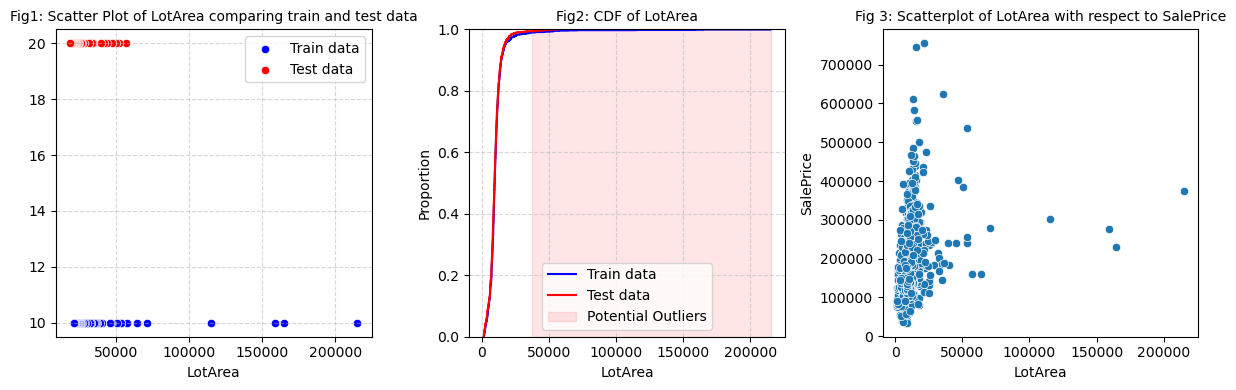

In [168]:
#LOTAREA
outlier_analysis(train_df, test_df, "LotArea")

In Figure 1, we observe a few data points with LotArea values exceeding 100,000, which appear to be outliers, as they are significantly larger than the majority of the data points. Notably, such high values are absent in the test set, suggesting these extreme cases are unique to the training data.

In Figure 3, we can see that these data points with exceptionally high LotArea values do not correspond to proportionally high SalePrice values. Instead, they tend to have relatively low SalePrice values, indicating that these large LotArea properties might not follow the typical relationship between LotArea and SalePrice seen in the rest of the dataset.

Therefore we drop the values above 100000.

In [169]:
#DROP ENTRIES IN TRAIN_DF WITH "LotArea" > 100000
train_df = train_df[train_df["LotArea"] < 100000]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1456 non-null   int64  
 1   MSZoning       1456 non-null   object 
 2   LotFrontage    1200 non-null   float64
 3   LotArea        1456 non-null   int64  
 4   Street         1456 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1456 non-null   object 
 7   LandContour    1456 non-null   object 
 8   Utilities      1456 non-null   object 
 9   LotConfig      1456 non-null   object 
 10  LandSlope      1456 non-null   object 
 11  Neighborhood   1456 non-null   object 
 12  Condition1     1456 non-null   object 
 13  Condition2     1456 non-null   object 
 14  BldgType       1456 non-null   object 
 15  HouseStyle     1456 non-null   object 
 16  OverallQual    1456 non-null   int64  
 17  OverallCond    1456 non-null   int64  
 18  YearBuilt    

#### LotFrontage

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


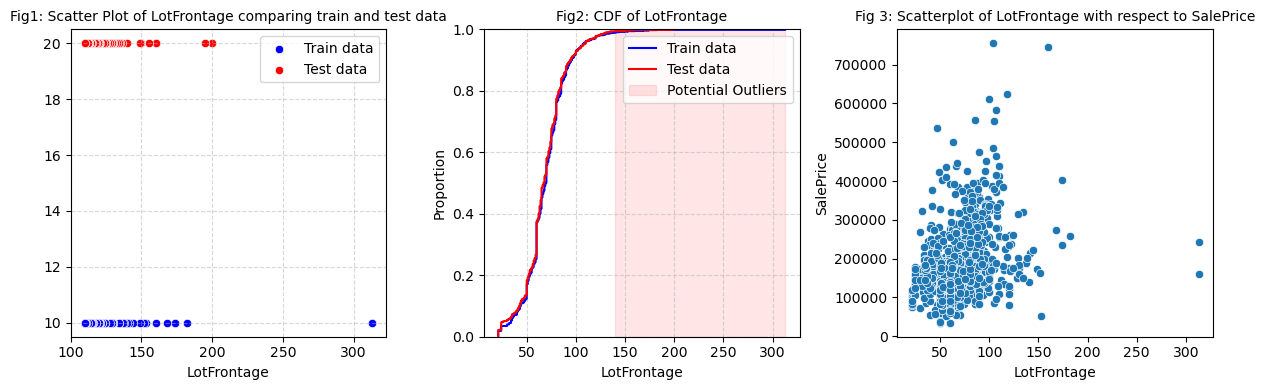

In [170]:
#LOTFRONTAGE
outlier_analysis(train_df, test_df, "LotFrontage")

For LotFrontage, we identify two outliers in the training set with values exceeding 200. These points deviate substantially from the main cluster of data and have no counterparts in the test set, highlighting their uniqueness to the training data.

As shown in the last figure, these high LotFrontage values do not exhibit a clear relationship with SalePrice, indicating that they may be anomalies or extreme cases that don’t align with the general trend of the data. Given their deviation and lack of predictive value, we will exclude all LotFrontage values above 200 from further analysis.

In [171]:
#DROP ENTRIES IN TRAIN_DF WITH "LotFrontage" > 200
train_df = train_df[train_df["LotFrontage"] < 200]

#### GrLivArea

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


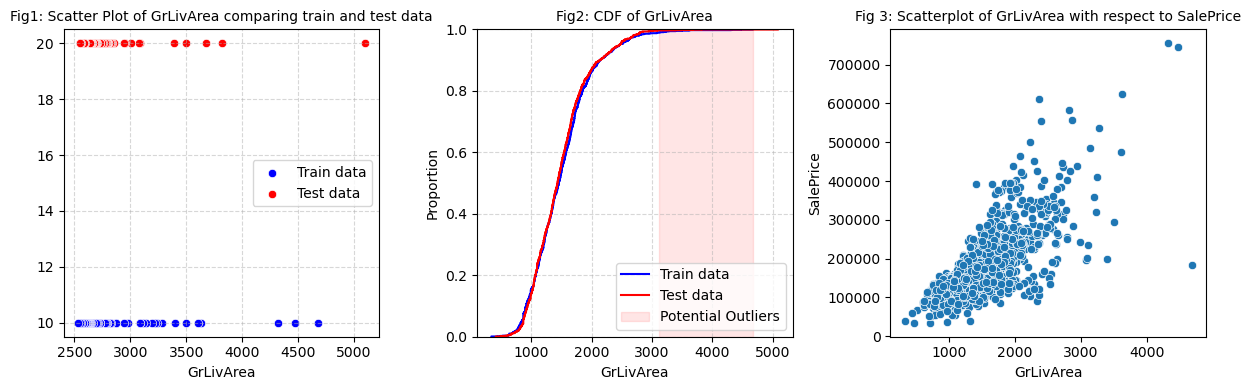

In [172]:
outlier_analysis(train_df, test_df, "GrLivArea")

We observe a single outlier in the traning set for *GrLivArea* with a value exceeding 4500 and an unusually low SalePrice.Therefore, we will exclude this data point from further analysis. 

In [173]:
#DROP ENTRIES IN TRAIN_DF WITH "GrLivArea" > 4500
train_df = train_df[train_df["GrLivArea"] < 4500]

#### BsmtFinSF1

In [ ]:
outlier_analysis(train_df, test_df, 'BsmtFinSF1')